# Conformal regression using Jackknife+-after-bootstrap in a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

This example demonstrates using `CoverForestRegressor` to perform Jackknife+-after-bootstrap in a scikit-learn pipeline with the diabetes dataset.

In [1]:
!pip install -q coverforest

import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from coverforest import CoverForestRegressor
from coverforest.metrics import average_interval_length_loss, regression_coverage_score

Load the dataset and split it into training and testing sets

In [2]:
X, y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Making a pipeline

We'll create a scikit-learn pipeline that normalizes the features first before fitting with `CoverForestRegressor`. Here, we specify `method='bootstrap'` to perform Jackknife+-after-bootstrap during fitting.

In [3]:
pipe_b = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "reg_b",
            CoverForestRegressor(n_estimators=400, method="bootstrap", random_state=0),
        ),
    ]
)

We'll now fit the pipeline on the training data.

In [4]:
pipe_b.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg_b',
                 CoverForestRegressor(method='bootstrap', n_estimators=400,
                                      random_state=0))])

Notice that the `fit()` method performs a hyperparameter search before the actual fitting, which as a result yields `k = 1` and `lambda = 0.1`.

## Inspecting individual tree

The `CoverForestRegressor` retains all `RandomForestRegressor`'s post-train attributes and methods. When `method='bootstrap'`, each subestimator in `CoverForestRegressor` is a scikit-learn's `DecisionTreeRegressor`. Let's take a look at one of these trees.

In [5]:
all_trees = pipe_b["reg_b"].estimators_
first_tree = all_trees[0]

first_tree

DecisionTreeRegressor(max_features='sqrt', random_state=441365315)

We can use scikit-learn's `tree.plot_tree` to plot individual trees.

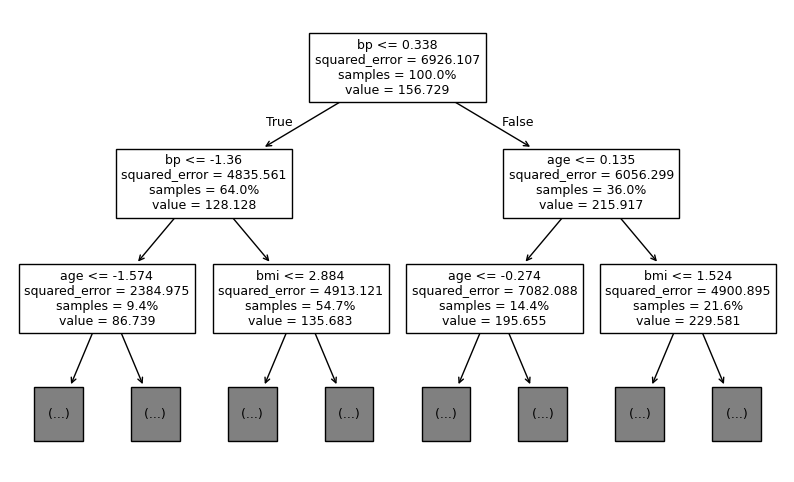

In [6]:
plt.figure(figsize=(10, 6))
tree.plot_tree(
    first_tree,
    feature_names=pipe_b["scaler"].get_feature_names_out(),
    max_depth=2,
    proportion=True,
    fontsize=9,
)
plt.show()

As another example, we also have access to the `feature_importances_` attribute after training.

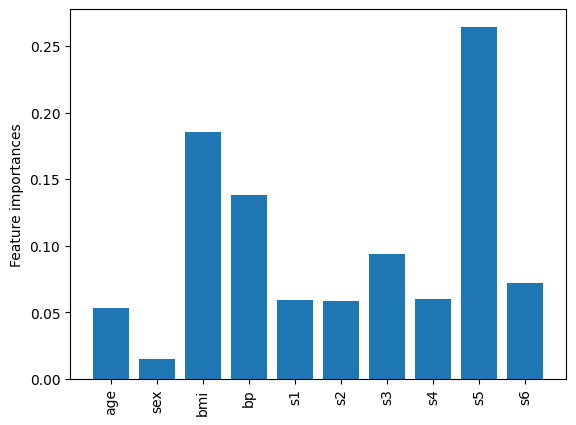

In [7]:
names = pipe_b["scaler"].get_feature_names_out()
importances = pipe_b["reg_b"].feature_importances_

fig, ax = plt.subplots()
ax.bar(names, importances)
ax.set_ylabel("Feature importances")
ax.tick_params(axis="x", labelrotation=90)
plt.show()

## Making interval predictions

Now we'll make predictions with 95% coverage ($\alpha=0.05$). This will return both the point predictions and the interval predictions.

In [8]:
y_b_pred, y_b_interval = pipe_b.predict(X_test, alpha=0.05)

Here, `y_b_pred` is an array of point predictions, which are the single values predicted by the model. `y_b_interval` is an array of shape `(n_test, 2)` where the first column is the lower bounds, and the second column is the upper bounds of the intervals.

Let's visualize these intervals. First, we define a convenient function that will be used to plot our predictions.

In [9]:
def plot_predictions_with_intervals(y_test, y_pred, y_interval):
    """Plot the test values, predictions, and prediction intervals"""

    x = np.arange(len(y_test))

    sort_idx = np.argsort(y_pred)
    y_test = y_test.iloc[sort_idx]
    y_pred = y_pred[sort_idx]
    y_interval = y_interval[sort_idx]

    plt.figure(figsize=(12, 6))

    for i in x:
        plt.vlines(i, y_interval[i, 0], y_interval[i, 1], color="blue", alpha=0.3)

    plt.scatter(x, y_test, s=8, color="r", label="Actual Values", zorder=5)

    plt.scatter(
        x, y_pred, s=8, color="blue", label="Predictions", linewidth=2, zorder=4
    )

    plt.ylabel("Disease progression", fontsize=20)
    plt.legend(fontsize="x-large")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

We'll now use this function. From the theory, 95% of these intervals should contain the actual values of $y$.

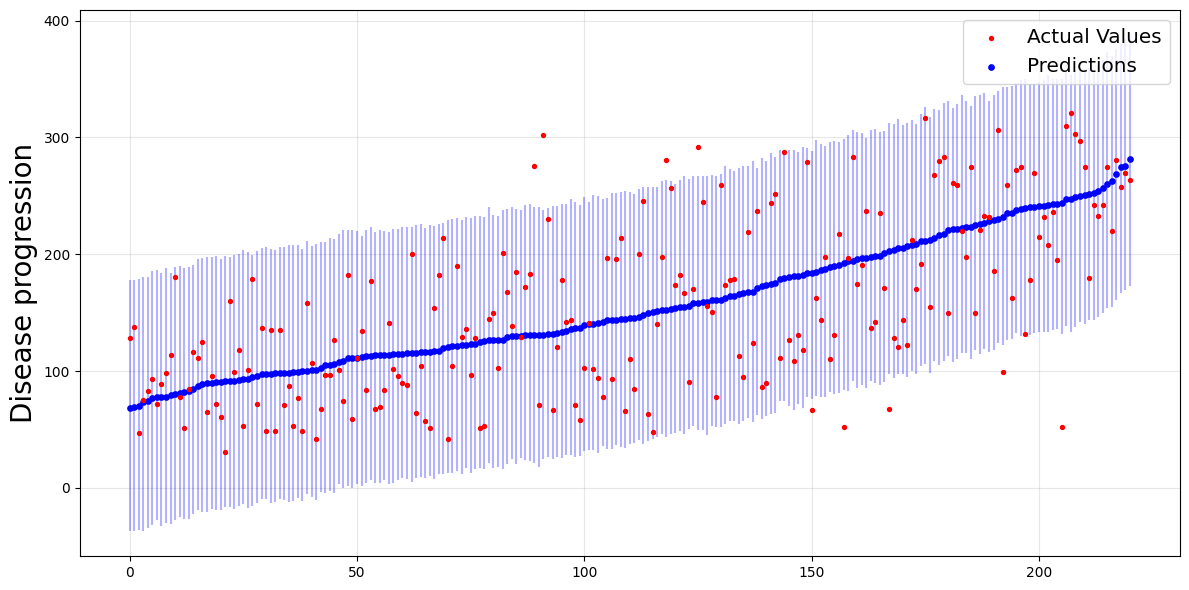

In [10]:
plot_predictions_with_intervals(y_test, y_b_pred, y_b_interval)

The intervals are the blue vertical lines, which are wide enough to contain most of the actual values (the red points).

## Evaluations

The `coverforest.metrics` module provides two metrics for evaluation of interval predictions.

- `average_interval_length_loss` calculates the average interval length. Small values indicate that our model's predictions are quite accurate.
- `regression_coverage_score` calculates the *empirical coverage`, that is, the proportion of intervals that contain the actual values. Higher coverage scores are better, especially when making risky decisions. The standard guaranteed lower bound on the coverage probability is $1-2\alpha$. Nonetheless, in practice, a good conformal algorithm should have empirical coverage more than $1-\alpha$.

In [11]:
print(f"Average length: {average_interval_length_loss(y_test, y_b_interval)}")
print(f"Empirical coverage: {regression_coverage_score(y_test, y_b_interval)}")

Average length: 216.6140370279263
Empirical coverage: 0.9547511312217195


For Jackknife+-after-bootstrap, the empirical coverage is above our target level of 0.95.

## Comparison with CV+ and split conformal

Let's try conformal regression with CV+ and split conformal as well and see how they perform compared to the Jackknife+-after-bootstrap.

### CV+

To perform CV+, we instantiate `CoverForestRegressor` with `method='cv'`.

In [12]:
pipe_cv = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "reg_cv",
            CoverForestRegressor(n_estimators=400, method="cv", cv=20, random_state=0),
        ),
    ]
)
pipe_cv.fit(X_train, y_train)
y_cv_pred, y_cv_interval = pipe_cv.predict(X_test, alpha=0.05)

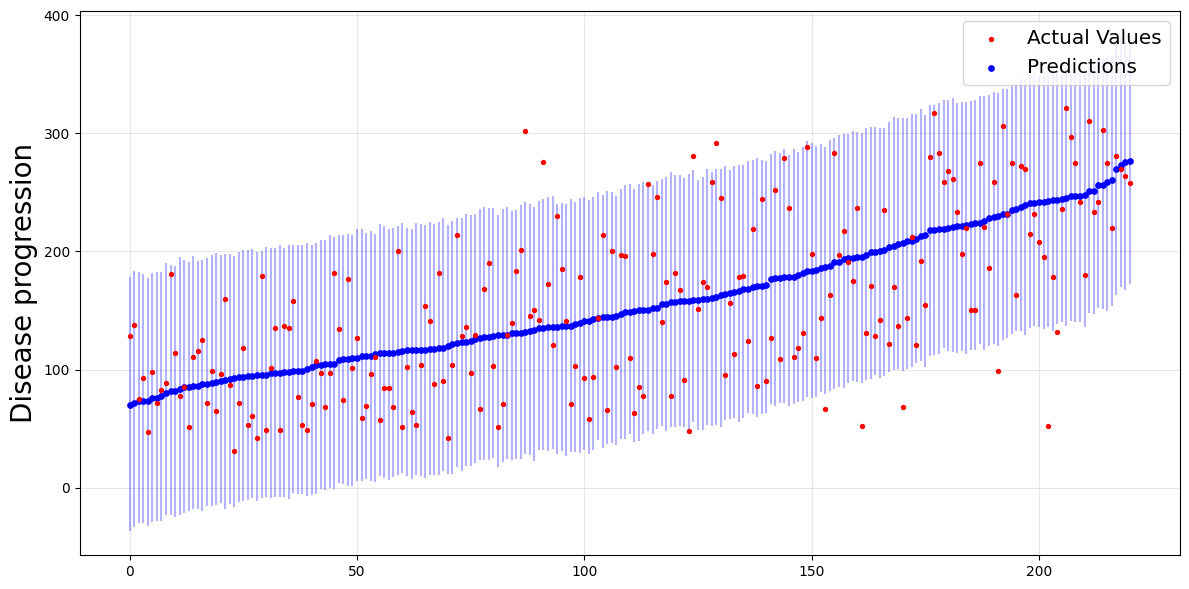

In [13]:
plot_predictions_with_intervals(y_test, y_cv_pred, y_cv_interval)

In [14]:
print(f"Average length: {average_interval_length_loss(y_test, y_cv_interval)}")
print(f"Empirical coverage: {regression_coverage_score(y_test, y_cv_interval)}")

Average length: 212.77281674208146
Empirical coverage: 0.9502262443438914


Compared to Jackknife+-after-boostrap, the average length and the empirical coverage are smaller.

### Split conformal

To perform split conformal, we instantiate `CoverForestRegressor` with `method='split'`.

In [15]:
pipe_sp = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "reg_sp",
            CoverForestRegressor(n_estimators=400, method="split", random_state=0),
        ),
    ]
)
pipe_sp.fit(X_train, y_train)
y_sp_pred, y_sp_interval = pipe_sp.predict(X_test, alpha=0.05)

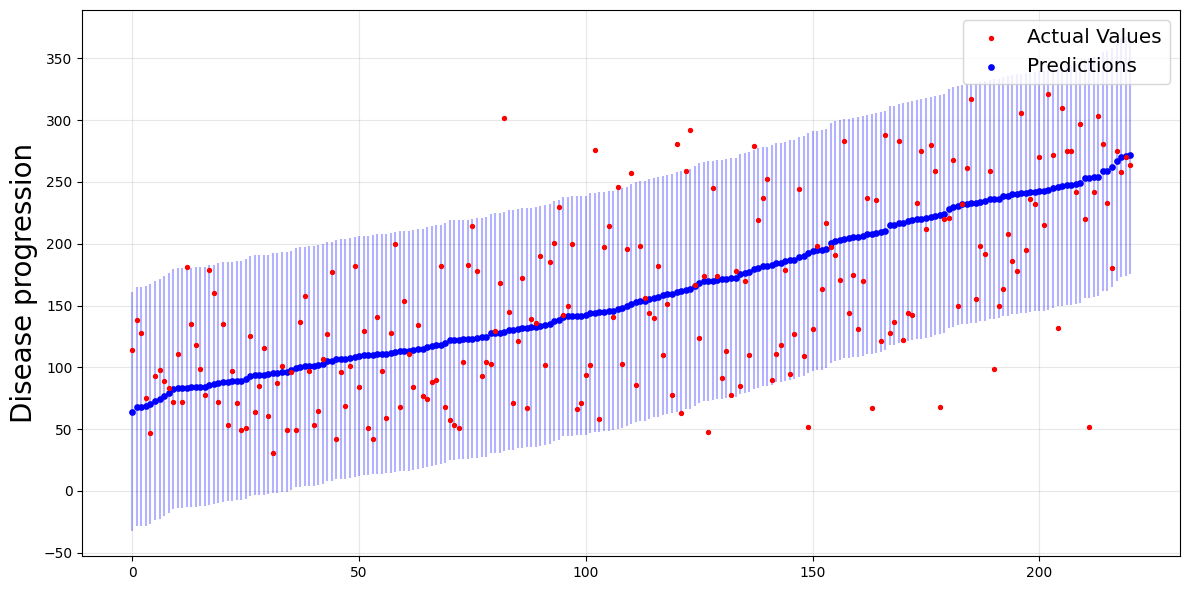

In [16]:
plot_predictions_with_intervals(y_test, y_sp_pred, y_sp_interval)

In [17]:
print(f"Average length: {average_interval_length_loss(y_test, y_sp_interval)}")
print(f"Empirical coverage: {regression_coverage_score(y_test, y_sp_interval)}")

Average length: 193.825
Empirical coverage: 0.9276018099547512


Even though the average length is smaller than the previous two methods, its coverage is below the desired level of 0.95.

## Final notes

1. The CV+ method is the only one with random forests as the sub-estimators
2. In the case of Jackknife+-after-bootstrap, the coverage guarantee in {footcite:t}`Kim2020` relies on resampling the forest's tree count from $\operatorname{Binomial}(B (1-1/n)^m)$, where:
   - $B$ is the initial number of trees
   - $n$ is the number of training samples
   - $m$ is the number of bootstrap samples.

   The `fit()` method in `CoverForestRegressor` automatically sets $B= \text{n_estimators}/(1-1/n)^m$ so that, on average, the number of trees to be fitted is $\text{n_estimators}$, with standard deviation of $\sqrt{\text{n_estimators}*(1- (1-1/n)^m)}$.

   `CoverForestRegressor` also provides an option not to resample the number of sub-estimators by initiating  with `resample_n_estimators=False`.
3. Random forest leverages parallel computation by processing trees concurrently. Use the `n_jobs` parameter in `fit()` and `predict()` to control CPU usage (`n_jobs=-1` uses all cores).
4. For prediction, conformity score calculations require a memory array of size `(n_train × n_test × n_classes)`. To optimize performance with high `n_jobs` values, split large test sets into smaller batches.

```{bibliography} references.bib
```